In [1]:
'''
Code provided by Philippine Space Agency on March 15 to 17 2023
plotting section edited by S Visaga
to use cartopy instead of basemap
'''

import netCDF4
import numpy as np
#from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
import glob
import os
import time

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
### Function to plot basemap and lon lat labels ###
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'),facecolor='none', edgecolor='black',linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'),facecolor='none', edgecolor='black', linewidth=1) 
    return ax

def plot_ticks(ax):
    ax.set_yticks(np.arange(4, 22, 5), crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(115, 128, 5), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    return ax

In [3]:
#List all netcd4 files in the directory using glob to filter ".nc" file extensions
l_files = glob.glob("*.nc")
print(l_files)

['GK2_GEMS_L2_20220501_0745_NO2_FW_DPRO_ORI.nc']


In [4]:
#Create a list for date, time, NO2 data, lat and lon that will be extracted from the nc files
l_dates = list()
l_times = list()
l_ColumnAmountNO2 = list()
l_lat = list()
l_lon = list()

In [6]:
#Loop for extraction of information from the netCDF4 files contained in l_files. 
for i in range(0,len(l_files)):
    print(i)
    # Get date and time information from the filename
    s_temp = str(l_files[i])
    sdate = s_temp.split('_')[3] #date information
    stime = s_temp.split('_')[4] #time information
    l_dates.append(sdate)
    l_times.append(stime)
        
    # Get variables in the netCDF4. 
    src = netCDF4.Dataset(l_files[i]) 
    data_fields = src.groups['Data Fields'] 
    print('Dataset', src)
    print('Data variables', data_fields)
    
    #Get NO2 data, latitude and longitude
    ColumnAmountNO2 = src.groups['Data Fields'].variables['ColumnAmountNO2']
    lat = src.groups['Geolocation Fields'].variables['Latitude']
    lon = src.groups['Geolocation Fields'].variables['Longitude']
    fv = ColumnAmountNO2._FillValue
    print('Column Amount NO2 Metadata', ColumnAmountNO2, 
          'Filling Value',fv)
    
    # NO2 data scaling to 10^16 and fill values
    m_ColumnAmountNO2 = np.fliplr(np.flipud(np.array(ColumnAmountNO2[:])))
    m_ColumnAmountNO2[m_ColumnAmountNO2 == fv] = np.nan
    m_ColumnAmountNO2 = m_ColumnAmountNO2 / 1e16
    
    # Geolocation values
    m_lat = np.fliplr(np.flipud(np.array(lat[:])))
    m_lon = np.fliplr(np.flipud(np.array(lon[:])))
    m_lat[m_lat == -fv] = np.nan
    m_lon[m_lon == fv] = np.nan
    
    # output data to list
    l_ColumnAmountNO2.append(m_ColumnAmountNO2)
    l_lat.append(m_lat)
    l_lon.append(m_lon)

0
Dataset <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Layer(69), image(695), spatial(2048), nwavel(75)
    variables(dimensions): 
    groups: Data Fields, Geolocation Fields, METADATA
Data variables <class 'netCDF4._netCDF4.Group'>
group /Data Fields:
    dimensions(sizes): 
    variables(dimensions): float32 AerosolOpticalDepth(AOD)(spatial, image), float32 AerosolLayerHeigth(ALH)(spatial, image), int16 AlgorithmQualityFlags(spatial, image), int16 AMFQualityFlags(spatial, image), float32 AmfStrat(spatial, image), float32 AmfTrop(spatial, image), float32 GeometricAmf(spatial, image), float32 AprioriTropNO2profile(Layer, spatial, image), float32 AveragingKernel(Layer, spatial, image), float32 Pressure(Layer, spatial, image), float32 CloudFraction(spatial, image), float32 CloudPressure(spatial, image), float32 ColumnAmountNO2(spatial, image), float32 ColumnAmountNO2Strat(spatial, image), float32 ColumnAmountNO2Trop(spatial

In [7]:
m_ColumnAmountNO2[3].shape

(695,)

In [8]:
# Subset to whole PH bounds and make the matrix size similar
masked_lat = list()
masked_lon = list()

for i in range(0,len(l_ColumnAmountNO2)):
    
    temp_lat = l_lat[i].copy()
    temp_lat[temp_lat < 4.0] = np.nan
    temp_lat[temp_lat > 22.0] = np.nan
    
    temp_lon = l_lon[i].copy()
    temp_lon[temp_lon < 115.0] = np.nan
    temp_lon[temp_lon > 128.0] = np.nan

    masked_lat.append(temp_lat.copy())
    masked_lon.append(temp_lon.copy())

In [9]:
#Apply subset to NO2 data
masked_ColumnAmountNO2 = list()

for i in range(0,len(l_ColumnAmountNO2)):
    #print(i)
    temp_ColumnAmountNO2 = l_ColumnAmountNO2[i].copy()
    temp_ColumnAmountNO2[np.isnan(masked_lat[i]) == True] = np.nan
    temp_ColumnAmountNO2[np.isnan(masked_lon[i]) == True] = np.nan
    temp_ColumnAmountNO2[temp_ColumnAmountNO2 < 0] = np.nan
    masked_ColumnAmountNO2.append(temp_ColumnAmountNO2.copy())

In [10]:
lat_min = np.nanmin(masked_lat[i])
lat_max = np.nanmax(masked_lat[i])
lon_min = np.nanmin(masked_lon[i])
lon_max = np.nanmax(masked_lon[i])

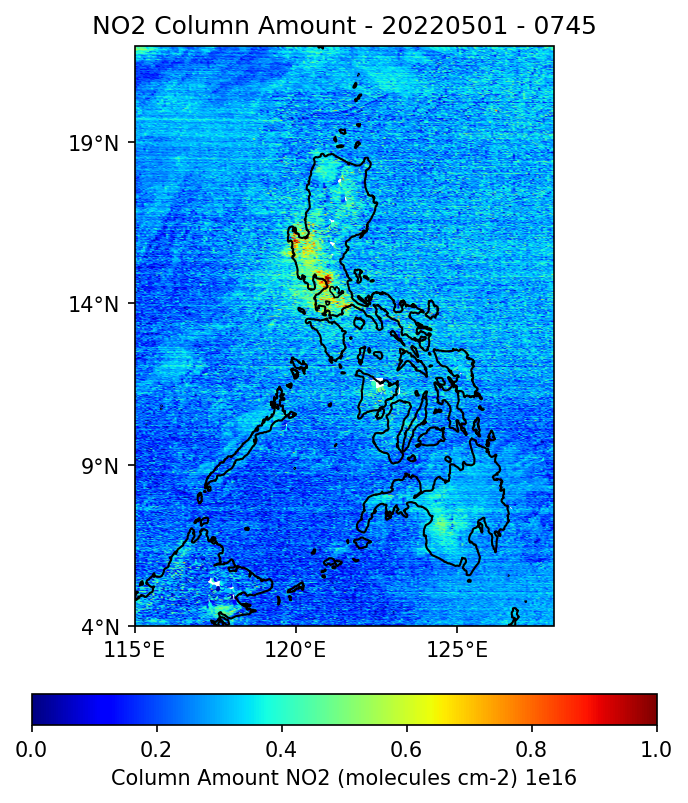

In [12]:
color_scale = 'gist_stern_r'         
vmin=0
vmax=1.         
for i in range(0,len(l_ColumnAmountNO2)):
    
    fig = plt.figure(figsize=(8, 6), dpi=150)

    ax = plt.axes(projection=ccrs.PlateCarree())
    plot_background(ax)
    plot_ticks(ax)
    img = ax.scatter(
            masked_lon[i],
            masked_lat[i],
            c=masked_ColumnAmountNO2[i],
            cmap='jet',
            marker='o',
            s=2, vmin = vmin, vmax = vmax,
            transform=ccrs.PlateCarree(),
        )
    ax.set_xlim(115,128)
    ax.set_ylim(4,22)
    #cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal',  label=r'Column Amount NO2 (molecules cm-2) 1e16', fraction=0.046, pad=0.1)

    plt.title('NO2 Column Amount - '+l_dates[i]+' - '+l_times[i])    
    plt.savefig('NO2_Figures/NO2_' + l_dates[i] + "_" + l_times[i] + ".jpg",  facecolor='white', bbox_inches="tight")
    plt.show()
    #plt.close('all')